# Status Torsdag d. 16-02-23 kl.15:38

I morgen (fredag) skal jeg prøve at plotte power sepctrummet for neutrinoer fra min egen kode. 

læse lidt op på den der artikel Thomas sendt om forskellige slags power spectrummer

In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc

import scipy.interpolate

# Metode  1 - fra den første artikel

ligninger 

for $\delta_{cdm}$

$\dot{\delta}_{cdm} = - \theta_{cdm}$

$\dot{\theta}_{cdm} = - \mathcal{H}a\theta_{cdm} - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a} \delta_{cdm}$

baseret på https://arxiv.org/abs/1602.05933 med e ekstra faktor a på $\mathcal{H}$ i $\dot{\theta}_{cdm}$

ved neutrinoer er $\dot{\delta}$ den samme.

$\dot{\theta}_{\nu}   =  -\mathcal{H}a\theta_{\nu} - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a} \delta_{cdm} + k^2  cs^2 \delta_{\nu}$


In [2]:
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
H0 = 67 / (3*1e5) # i 1/Mpc
mv_test = 1 # eV
kvec = np.logspace(-3,1,30)
h = 0.6704
cosmo_dict ={'h':h,  'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6

Text(0.5, 1.0, 'neutrino power sepctrum for a neutrino of mass 1 eV')

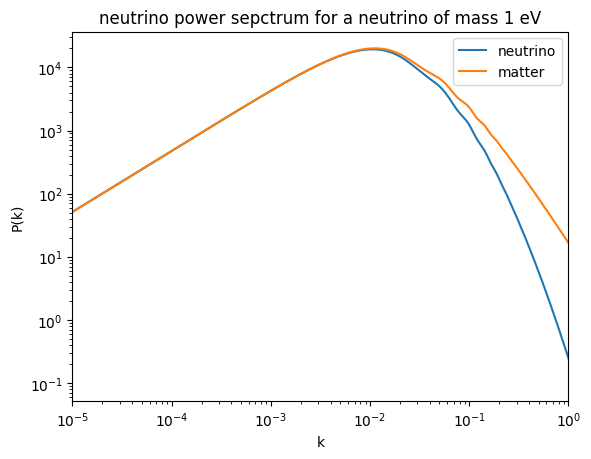

In [3]:
tranf = cosmo.get_transfer(z=0)
#print(tranf.keys())
prim = cosmo.get_primordial()
#print(prim.keys())

k = tranf['k (h/Mpc)'] * h
#print(k)
#plt.loglog(tranf['k (h/Mpc)'],-tranf["d_ncdm[0]"])

prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
plt.figure(1)
#print(tranf["d_ncdm[0]"])

plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"]**2* k**(-3) * prim_interp(k) * h**3,label="neutrino")
plt.loglog(k, 2*np.pi**2 * tranf["d_m"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
plt.xlim([1e-5,1])
plt.legend()
plt.xlabel("k")
plt.ylabel("P(k)")
plt.title("neutrino power sepctrum for a neutrino of mass %s eV" % mv_test)
#plt.ylim([1e-3,1e1])
#plt.show()

In [4]:

def simuler(mv_test, # eV
            kvec,factor = 2.68,T_ini1 = 1000,H0 = 67.810,crazy = False):
    
    Res = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren
    


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed
    
    if crazy == False:
        def cs(a,mv,factor):
            return factor * Tv(a) / mv
    else:
        def cs(a,mv,factor):
            return (factor * Tv(a) / mv)**2

    
    # udregn a
    def a_solve(τ,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # sammenlignings data fra Class

    
    def cdm_func(τ,y):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   =  - nabla2phi -  H(a) * theta * a
        return [d_delta,d_theta]

    
    for k_ind1,k in enumerate(kvec):
        
        
        delta_class1 = pts[k_ind1]["delta_cdm"]
        theta_class1 = pts[k_ind1]["theta_cdm"]
        tau_class1 = pts[k_ind1]["tau [Mpc]"]
        delta_neutrino_class1 = pts[k_ind1]["delta_ncdm[0]"]
        theta_neutrino_class1 = pts[k_ind1]["theta_ncdm[0]"]
        a_class1 = pts[k_ind1]["a"]

        delta_init1 = scipy.interpolate.interp1d(tau_class1,delta_class1)(T_ini1)
        theta_init1 = scipy.interpolate.interp1d(tau_class1,theta_class1)(T_ini1)
        delta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,delta_neutrino_class1)(T_ini1)
        theta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,theta_neutrino_class1)(T_ini1)
        
        
        # T-span1
        t_span1 = [T_ini1,tau[-1]]

        y01 = [delta_init1,theta_init1]

        sol_cdm1 = sc.solve_ivp(cdm_func, t_span = t_span1, y0 = y01)

        t_cdm1 = sol_cdm1.t
        delta_cdm1 = sol_cdm1.y[0]


        delta_cdm_interp1 = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

        def neu_func(τ,y,k,mv,factor):
            delta = y[0]
            theta = y[1]    
            a = a_interp(τ)
            d_delta   = - theta
            delta_cdm = delta_cdm_interp1(τ)
            d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta 
            return [d_delta,d_theta]


        y01_neutrino = [delta_neutrino_init1,theta_neutrino_init1]
        sol_neu1 = sc.solve_ivp(neu_func, t_span = t_span1, y0 = y01_neutrino,args=(k,mv,factor))
        
        Res[k_ind1] = sol_neu1.y[0][-1]
        
    tranf = cosmo.get_transfer(z=0)
    #print(tranf.keys())
    prim = cosmo.get_primordial()
    #print(prim.keys())

    k = tranf['k (h/Mpc)'] * h
    kvec = np.array(kvec)
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    plt.figure(1)
    #print(k)
    plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"]**2* k**(-3) * prim_interp(k) * h**3,label="neutrino")
    plt.loglog(k, 2*np.pi**2 * tranf["d_m"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
    plt.loglog(kvec,2*np.pi**2 * Res**2 * kvec**(-3) * prim_interp(kvec)*h**3,label="min")
    plt.title("mv = %s eV T_ini = %s cs-factor = %s "%(mv_test,T_ini1,factor))
    plt.legend()
    
    plt.xlim([kvec[0],kvec[-1]])

    return None


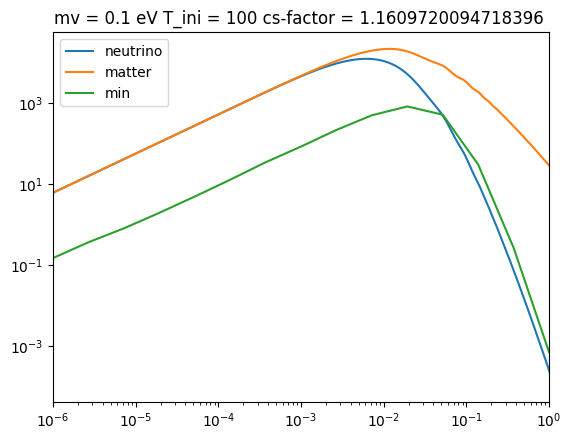

In [5]:
mv_test = 1e-1
import scipy.special as special
cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
cs_factor /= 4
kvec = list(np.logspace(-6,0,15))
simuler(mv_test = 1e-1, # eV
        kvec=kvec,factor = cs_factor,T_ini1 = 100)

In [6]:
"""mv_test = 1e-1
kvec = list(np.logspace(-6,0,15))
simuler(mv_test, # eV
        kvec,factor = 100,T_ini1 = 100)"""

'mv_test = 1e-1\nkvec = list(np.logspace(-6,0,15))\nsimuler(mv_test, # eV\n        kvec,factor = 100,T_ini1 = 100)'

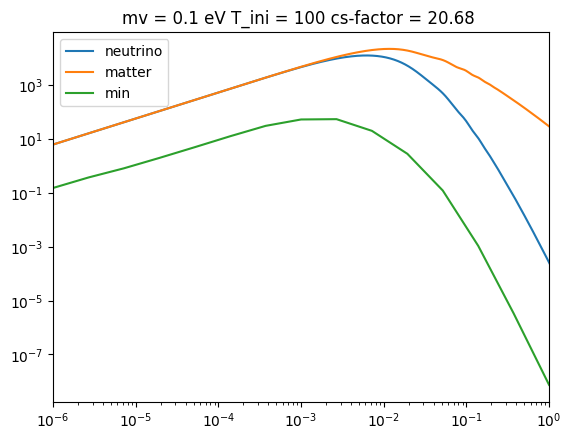

In [7]:
mv_test = 1e-1
kvec = list(np.logspace(-6,0,15))
simuler(mv_test, # eV
        kvec,factor = 20.68,T_ini1 = 100)

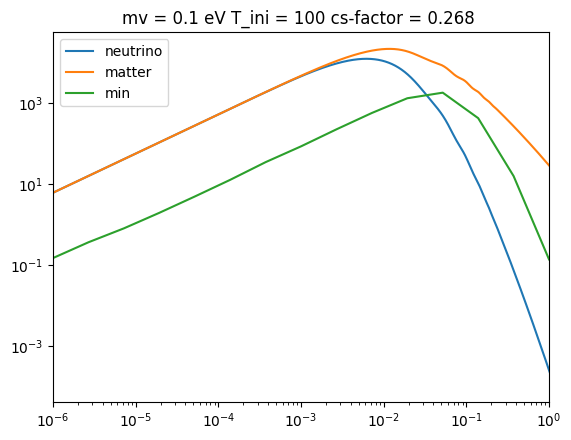

In [8]:
mv_test = 1e-1
kvec = list(np.logspace(-6,0,15))
simuler(mv_test, # eV
        kvec,factor = 0.268,T_ini1 = 100)

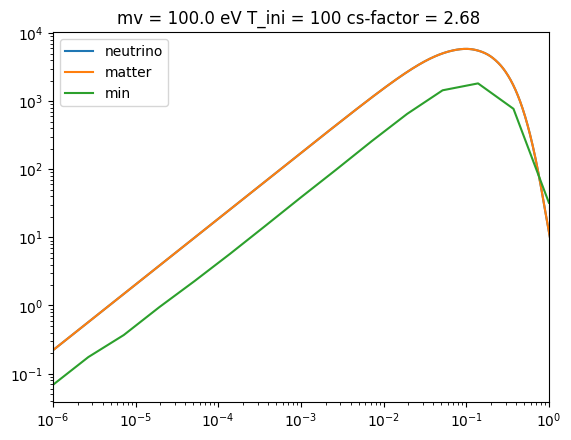

In [9]:
mv_test = 1e2
kvec = list(np.logspace(-6,0,15))
simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 100)

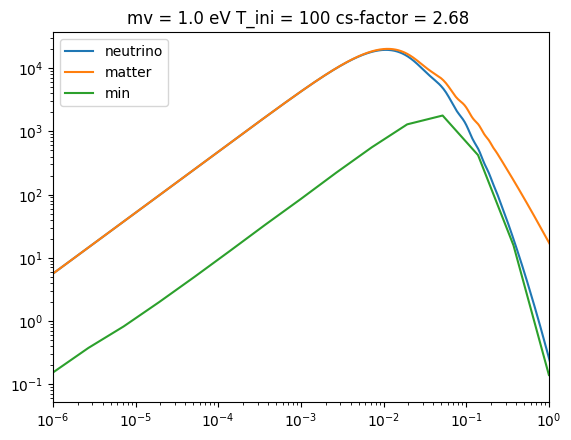

In [10]:
mv_test = 1e0
kvec = list(np.logspace(-6,0,15))
simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 100)

(0.001, 1.0)

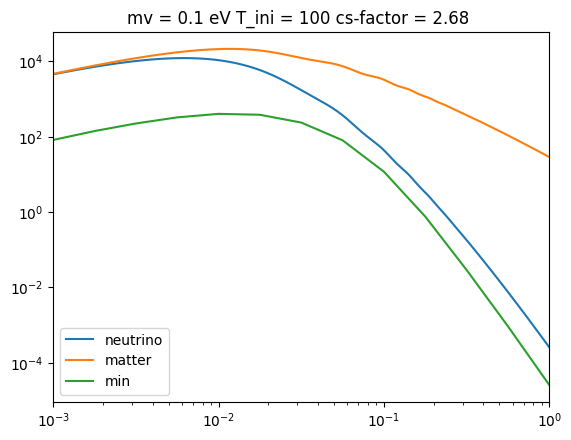

In [11]:
mv_test = 1e-1
kvec = list(np.logspace(-6,0,25))
simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 100)
plt.xlim([1e-3,kvec[-1]])

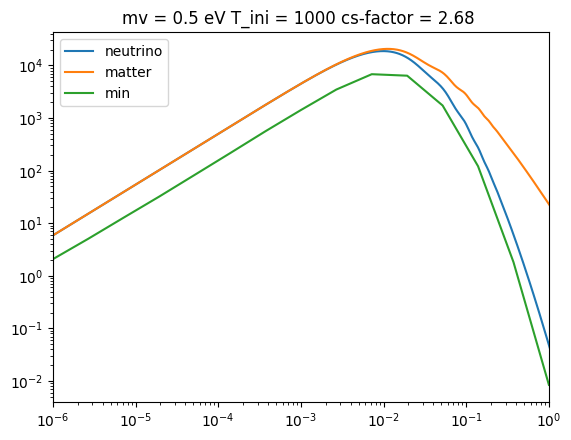

In [12]:
mv_test = 5e-1
kvec = list(np.logspace(-6,0,15))
simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 1000)

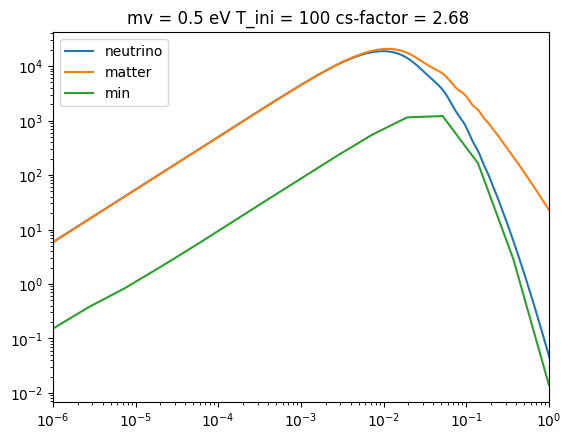

In [13]:
mv_test = 5e-1
kvec = list(np.logspace(-6,0,15))
simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 100)

In [14]:

def simuler1(mv_test, # eV
            kvec,factor = 2.68,T_ini1 = 1000,H0 = 67.810):
    
    Res = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren
    


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(tau,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # sammenlignings data fra Class


    def func(τ,y,k,mv,factor):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        d_theta   =  - (3/2) * H0*H0 * Omega_M * delta / a -  H(a) * theta * a
        delta_nu = y[2]
        theta_nu = y[3]
        d_delta_nu   = - theta_nu
        d_theta_nu   =  -  H(a) * a * theta_nu - (3/2) * H0*H0 * Omega_M * delta / a  + k**2 * cs(a,mv,factor)**2 * delta_nu
        return [d_delta,d_theta,d_delta_nu,d_theta_nu]

    for k_ind1,k in enumerate(kvec):
        
        
        delta_class1 = pts[k_ind1]["delta_cdm"]
        theta_class1 = pts[k_ind1]["theta_cdm"]
        tau_class1 = pts[k_ind1]["tau [Mpc]"]
        delta_neutrino_class1 = pts[k_ind1]["delta_ncdm[0]"]
        theta_neutrino_class1 = pts[k_ind1]["theta_ncdm[0]"]
        a_class1 = pts[k_ind1]["a"]

        delta_init1 = scipy.interpolate.interp1d(tau_class1,delta_class1)(T_ini1)
        theta_init1 = scipy.interpolate.interp1d(tau_class1,theta_class1)(T_ini1)
        delta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,delta_neutrino_class1)(T_ini1)
        theta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,theta_neutrino_class1)(T_ini1)
        τ_span = [T_ini1,tau[-1]]



        y0 = [delta_init1,theta_init1,delta_neutrino_init1,theta_neutrino_init1]

        sol = sc.solve_ivp(func, t_span = τ_span, y0 = y0,args=(k,mv,factor))

        τ_cdm = sol.t
        delta_cdm = sol.y[0]
        delta_nu = sol.y[2]

        
        Res[k_ind1] = delta_nu[-1]
        
    tranf = cosmo.get_transfer(z=0)
    #print(tranf.keys())
    prim = cosmo.get_primordial()
    #print(prim.keys())

    k = tranf['k (h/Mpc)'] * h
    kvec = np.array(kvec)
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    plt.figure(1)

    plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"]**2* k**(-3) * prim_interp(k) * h**3,label="neutrino")
    plt.loglog(k, 2*np.pi**2 * tranf["d_m"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
    plt.loglog(kvec,2*np.pi**2 * Res**2 * kvec**(-3) * prim_interp(kvec)*h**3,label="min")
    plt.title("mv = %s eV T_ini = %s cs-factor = %s "%(mv_test,T_ini1,factor))
    plt.legend()
    plt.xlim([kvec[0],kvec[-1]])

    return None



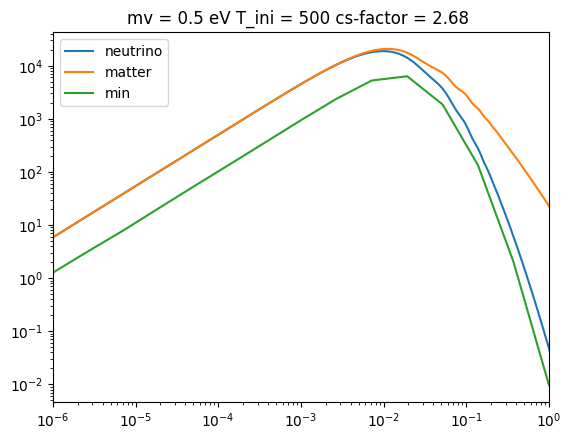

In [15]:
mv_test = 5e-1
kvec = list(np.logspace(-6,0,15))
simuler1(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 500)

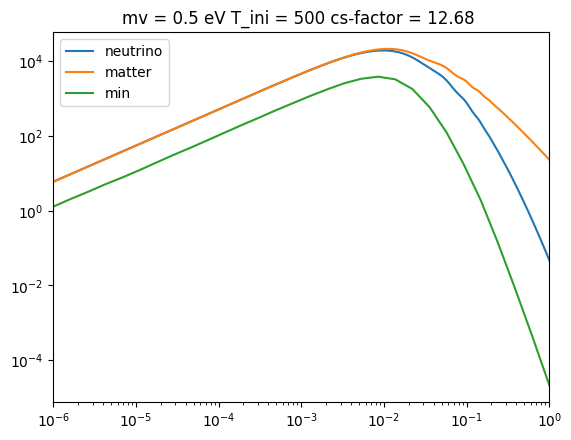

In [16]:
mv_test = 5e-1
kvec = list(np.logspace(-6,0,30))
simuler1(mv_test, # eV
        kvec,factor = 12.68,T_ini1 = 500)

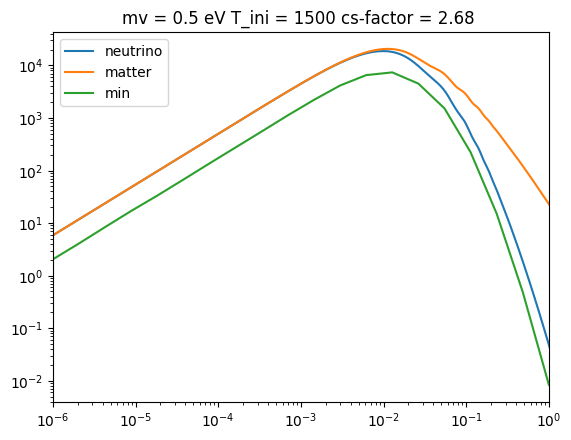

In [17]:
mv_test = 5e-1
kvec = list(np.logspace(-6,0,20))
simuler1(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 1500)

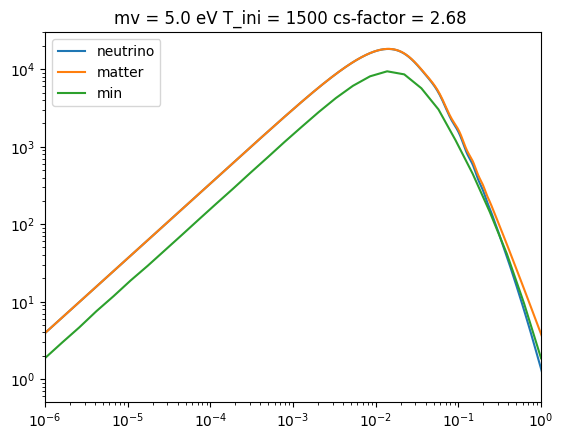

In [18]:
mv_test = 5e0
kvec = list(np.logspace(-6,0,30))
simuler1(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 1500)
#plt.xlim([1e-2,1e0])

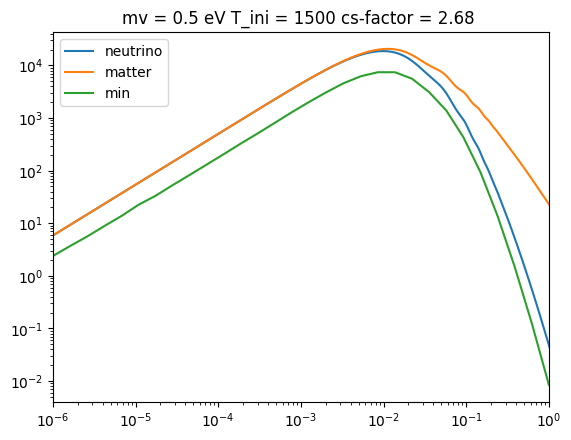

In [19]:
mv_test = 5e-1
kvec = list(np.logspace(-6,0,30))
simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 1500)
#plt.xlim([1e-2,1e0])

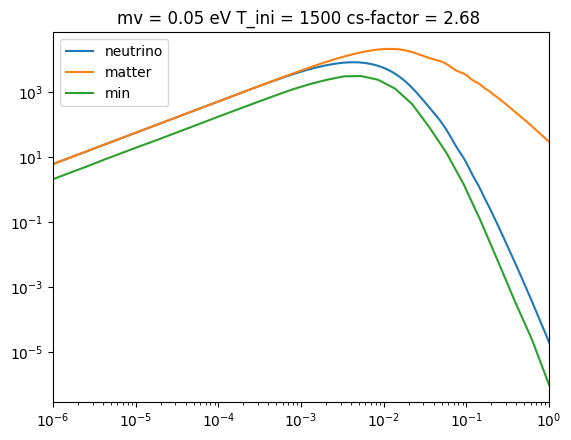

In [20]:
mv_test = 5e-2
kvec = list(np.logspace(-6,0,30))
simuler1(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 1500)


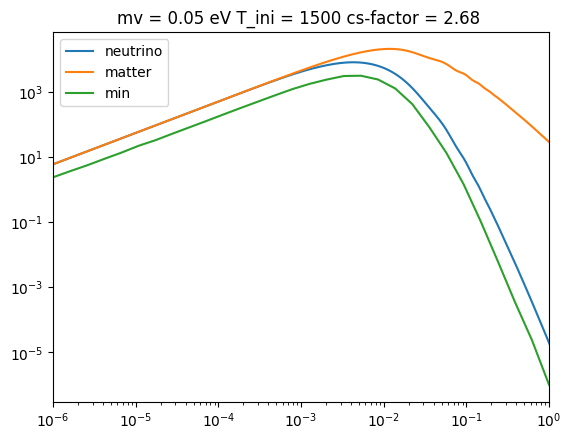

In [21]:

simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 1500)

In [22]:

def plot_delta(mv_test, # eV
            kvec,k_ind,factor = 2.68,T_ini1 = 1000,H0 = 67.810):
    
    Res = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    
    
    mv = mv_test * 1e-6
    


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(tau,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # sammenlignings data fra Class


    def func(τ,y,k,mv,factor):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        d_theta   =  - (3/2) * H0*H0 * Omega_M * delta / a -  H(a) * theta * a
        delta_nu = y[2]
        theta_nu = y[3]
        d_delta_nu   = - theta_nu
        d_theta_nu   =  -  H(a) * a * theta_nu - (3/2) * H0*H0 * Omega_M * delta / a  + k**2 * cs(a,mv,factor)**2 * delta_nu
        return [d_delta,d_theta,d_delta_nu,d_theta_nu]




    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]

    delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini1)
    theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini1)
    delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini1)
    theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini1)
    τ_span = [T_ini1,tau[-1]]



    y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]

    sol = sc.solve_ivp(func, t_span = τ_span, y0 = y0,args=(kvec[k_ind],mv,factor))

    τ_cdm = sol.t
    delta_cdm = sol.y[0]
    delta_nu = sol.y[2]
    plt.loglog(τ_cdm,-delta_nu,label="min-neutrino")
    plt.loglog(τ_cdm,-delta_cdm,label="min-cdm")
    plt.loglog(tau_class,-delta_class,label="class dcm")
    plt.loglog(tau_class,-delta_neutrino_class,label="class neutrino")
    plt.title("mv = %s eV T_ini = %s cs-factor = %s  k= %s"%(mv_test,T_ini1,factor,kvec[k_ind]))
    plt.legend()
    #plt.xlim([1e-6,1e0])

    return None

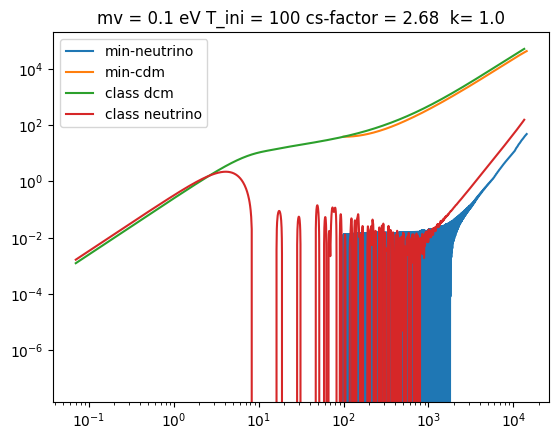

In [23]:
mv_test = 1e-1
kvec = [1e-2,1e-1,1e0,1e1]
k_ind = -2
plot_delta(mv_test,kvec,k_ind,T_ini1 = 100)

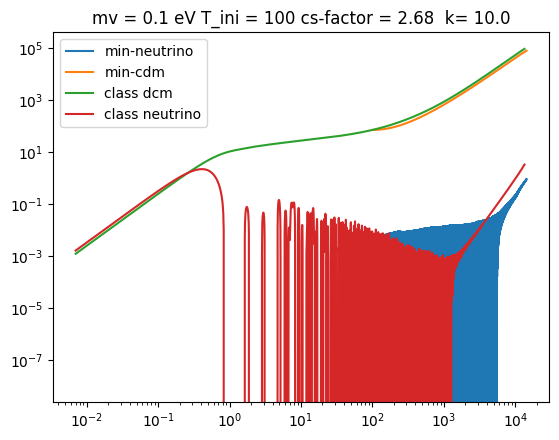

In [24]:
mv_test = 1e-1
kvec = [1e-2,1e-1,1e0,1e1]
k_ind = -1
plot_delta(mv_test,kvec,k_ind,T_ini1 = 100)

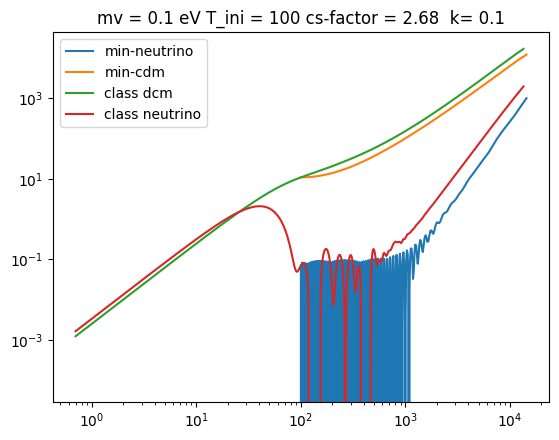

In [25]:
mv_test = 1e-1
kvec = [1e-2,1e-1,1e0,1e1]
k_ind = 1
plot_delta(mv_test,kvec,k_ind,T_ini1 = 100)

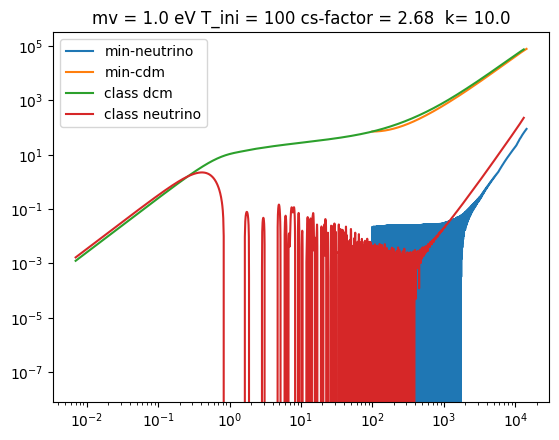

In [26]:
mv_test = 1e0
kvec = [1e-2,1e-1,1e0,1e1]
k_ind = -1
plot_delta(mv_test,kvec,k_ind,T_ini1 = 100)

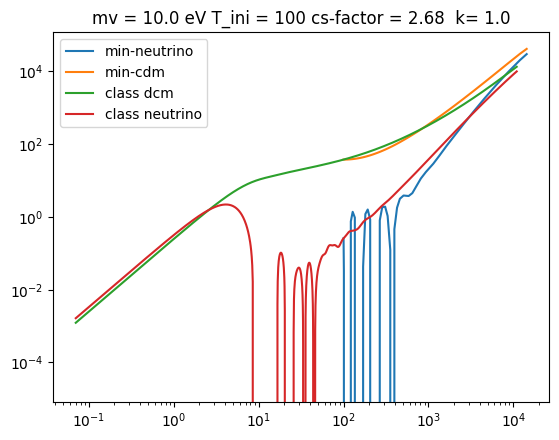

In [27]:
mv_test = 1e1
kvec = [1e-2,1e-1,1e0,1e1]
k_ind = -2
plot_delta(mv_test,kvec,k_ind,T_ini1 = 100)

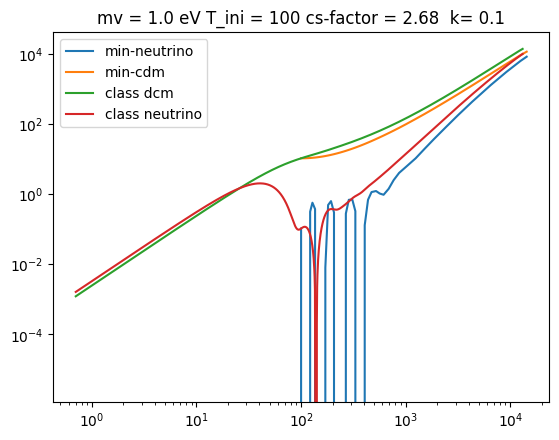

In [28]:
mv_test = 1e0
kvec = [1e-2,1e-1,1e0,1e1]
k_ind = 1
plot_delta(mv_test,kvec,k_ind,T_ini1 = 100)

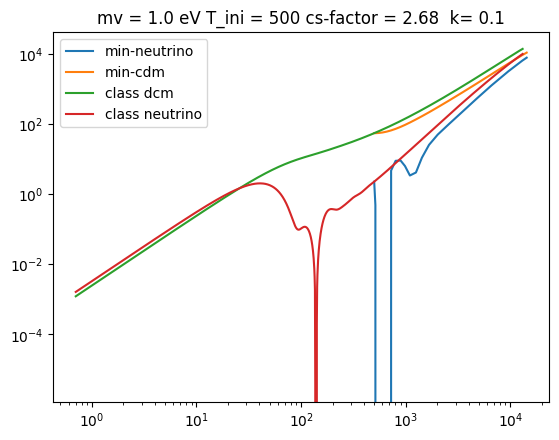

In [29]:
mv_test = 1e0
kvec = [1e-2,1e-1,1e0,1e1]
k_ind = 1
plot_delta(mv_test,kvec,k_ind,T_ini1 = 500)

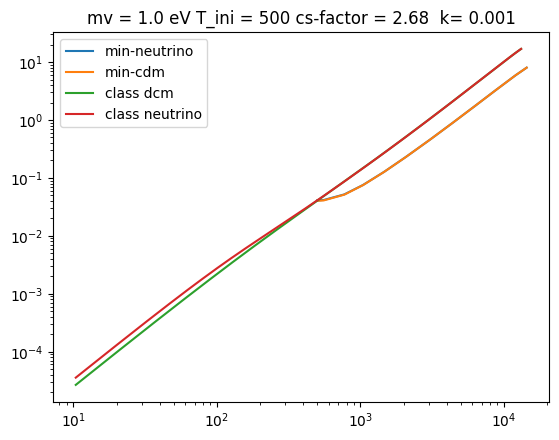

In [30]:
mv_test = 1e0
kvec = [1e-3,1e-2,1e-1,1e0,1e1]
k_ind = 0
plot_delta(mv_test,kvec,k_ind,T_ini1 = 500)

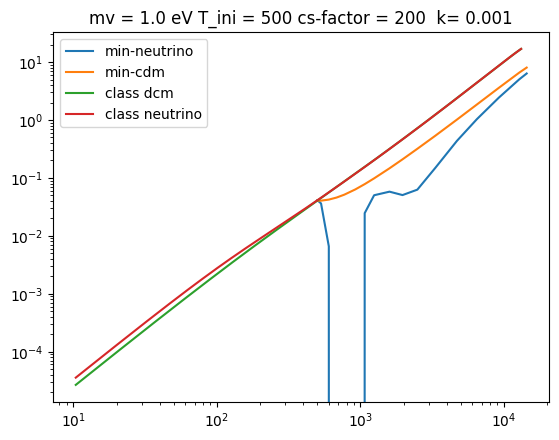

In [31]:
mv_test = 1e0
kvec = [1e-3,1e-2,1e-1,1e0,1e1]
k_ind = 0
plot_delta(mv_test,kvec,k_ind,factor = 200,T_ini1 = 500)

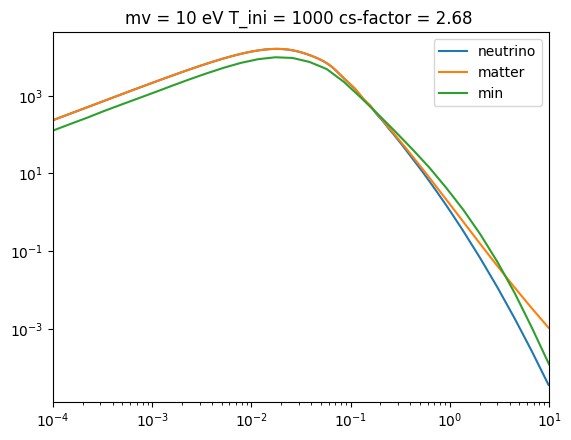

In [32]:
mv_test = 10
kvec =  list(np.logspace(-4,1,30))
simuler(mv_test,kvec)

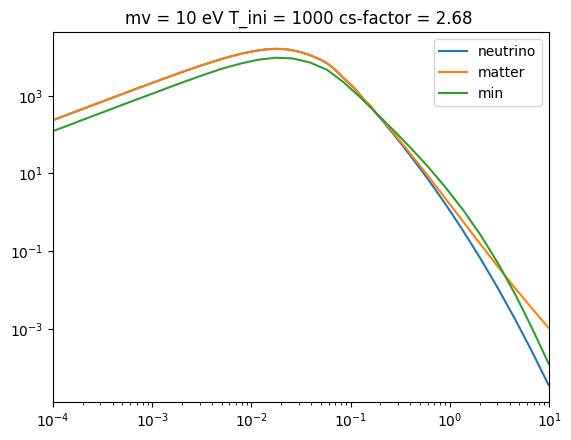

In [33]:
mv_test = 10
kvec =  list(np.logspace(-4,1,30))
simuler1(mv_test,kvec)

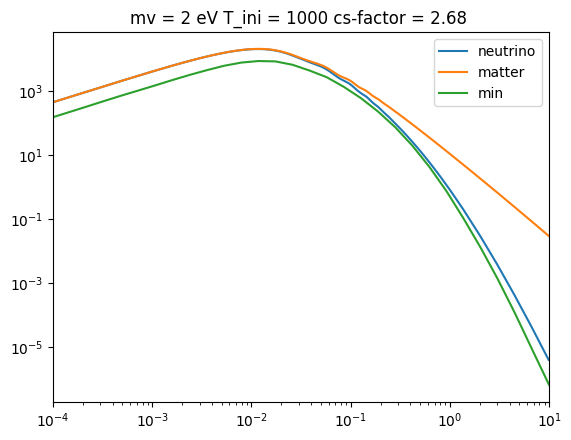

In [34]:
mv_test = 2
kvec =  list(np.logspace(-4,1,30))
simuler(mv_test,kvec)

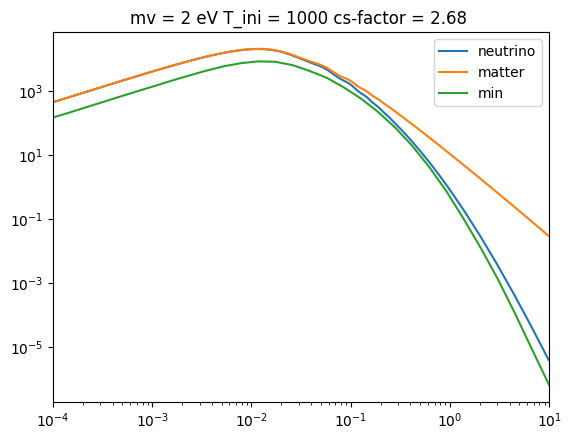

In [35]:
mv_test = 2
kvec =  list(np.logspace(-4,1,30))
simuler1(mv_test,kvec)

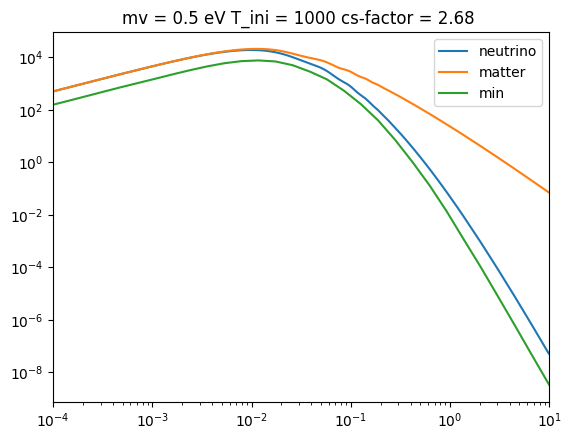

In [36]:
mv_test = 0.5
kvec =  list(np.logspace(-4,1,30))
simuler(mv_test,kvec)

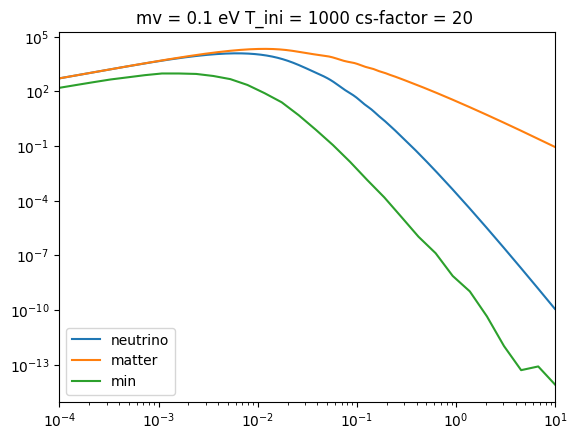

In [37]:
mv_test = 1e-1
kvec =  list(np.logspace(-4,1,30))
simuler(mv_test,kvec,factor=20)

In [38]:

def simuler2(mv_test, # eV
            kvec,factor = 2.68,T_ini1 = 1000,H0 = 67.810,crazy = False):
    
    Res = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren
    


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed
    
    if crazy == False:
        def cs(a,mv,factor):
            return factor * Tv(a) / mv
    else:
        def cs(a,mv,factor):
            return (factor * Tv(a) / mv)**2

    
    # udregn a
    def a_solve(τ,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # sammenlignings data fra Class

    
    def cdm_func(τ,y):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   =  - nabla2phi -  H(a) * theta * a
        return [d_delta,d_theta]

    
    for k_ind1,k in enumerate(kvec):
        
        
        delta_class1 = pts[k_ind1]["delta_cdm"]
        theta_class1 = pts[k_ind1]["theta_cdm"]
        tau_class1 = pts[k_ind1]["tau [Mpc]"]
        delta_neutrino_class1 = pts[k_ind1]["delta_ncdm[0]"]
        theta_neutrino_class1 = pts[k_ind1]["theta_ncdm[0]"]
        a_class1 = pts[k_ind1]["a"]

        delta_init1 = scipy.interpolate.interp1d(tau_class1,delta_class1)(T_ini1)
        theta_init1 = scipy.interpolate.interp1d(tau_class1,theta_class1)(T_ini1)
        delta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,delta_neutrino_class1)(T_ini1)
        theta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,theta_neutrino_class1)(T_ini1)
        
        
        # T-span1
        t_span1 = [T_ini1,tau[-1]]

        y01 = [delta_init1,theta_init1]

        sol_cdm1 = sc.solve_ivp(cdm_func, t_span = t_span1, y0 = y01)

        t_cdm1 = sol_cdm1.t
        delta_cdm1 = sol_cdm1.y[0]


        delta_cdm_interp1 = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

        def neu_func(τ,y,k,mv,factor):
            delta = y[0]
            theta = y[1]    
            a = a_interp(τ)
            d_delta   = - theta
            delta_cdm = delta_cdm_interp1(τ)
            d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor) * delta 
            return [d_delta,d_theta]


        y01_neutrino = [delta_neutrino_init1,theta_neutrino_init1]
        sol_neu1 = sc.solve_ivp(neu_func, t_span = t_span1, y0 = y01_neutrino,args=(k,mv,factor))
        
        Res[k_ind1] = sol_neu1.y[0][-1]
    tranf = cosmo.get_transfer(z=0)
    #print(tranf.keys())
    prim = cosmo.get_primordial()
    #print(prim.keys())

    k = tranf['k (h/Mpc)'] * h
    kvec = np.array(kvec)
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    plt.figure(1)
    #print(k)
    plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"]**2* k**(-3) * prim_interp(k) * h**3,label="neutrino")
    plt.loglog(k, 2*np.pi**2 * tranf["d_m"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
    plt.loglog(kvec,2*np.pi**2 * Res**2 * kvec**(-3) * prim_interp(kvec)*h**3,label="min")
    plt.title("mv = %s eV T_ini = %s cs-factor = %s "%(mv_test,T_ini1,factor))
    plt.legend()
    
    plt.xlim([kvec[0],kvec[-1]])

    return None

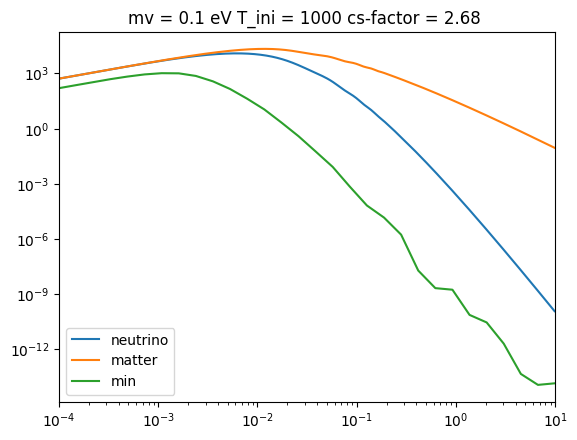

In [42]:
mv_test = 1e-1
kvec =  list(np.logspace(-4,1,30))
simuler2(mv_test,kvec)

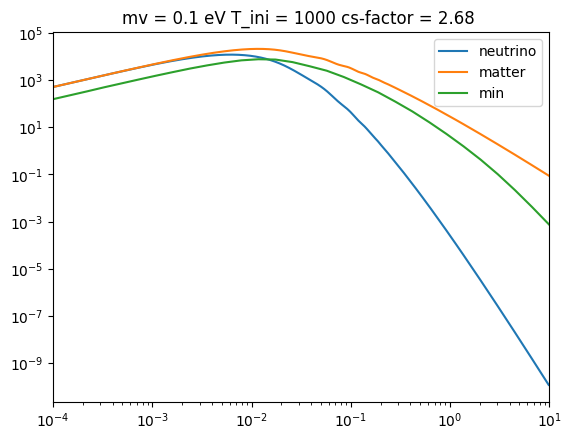

In [40]:
simuler(mv_test,kvec,crazy=True)

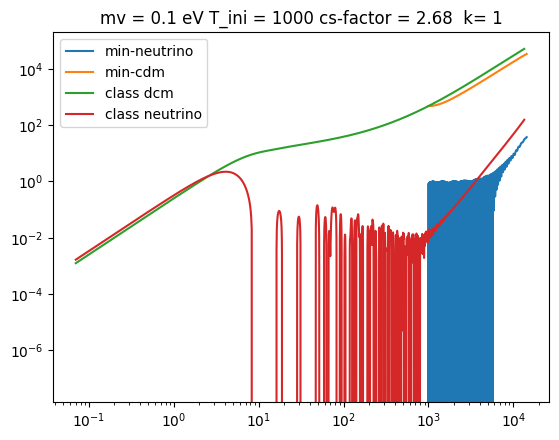

In [41]:
mv_test = 1e-1
#kvec =  list(np.logspace(-4,1,30))
kvec = [0.1,1,10]
plot_delta(mv_test,kvec,1)